# Single-Channel Blind Source Separation Using Convex Optimization

## Introduction

Source separations problems deal generally estimating component signals from from some one or more observed combinations of the signals. In blind source separation (BSS), you have no or little information about the underlying signals. In partiuclar, we suppose that we don't have a training dataset of separated signals with which to train a model.

In single-channel source separation, you measure a signal that is a mixture of other signals, and you estimate what the underlyings signalsa are. The mathematical model for this problem is

$$ x[t] = \sum_{k=1}^K s_k[t], $$

where $x[t]$ is the measured signal, and there are $K$ component signals, $s_k[t]$. This is generally more difficult than multi-channel source separation, where you have access to multiple observed channels, each with a different linear mixture of the component signals. 

One of the most common applications of this problem is noise filtering or smoothing. In this case, you only have two signals, the thing you are trying to measure and the noise in the measurement. There are many, many solutions to this problem, everything from [low-pass filters](https://en.wikipedia.org/wiki/Low-pass_filter) to [spline fits](https://en.wikipedia.org/wiki/Spline_interpolation). However, more interesting cases occur when there are more than one component signal that is not noise. In this case, the problem is highly [underdetermined](https://en.wikipedia.org/wiki/Underdetermined_system), meaning that there are many more unknowns than constraints, so there is no clear single or best solution. However, under a variety of conditions, it is possible to find useful solutions to the problem

In this post, we'll explore the use of convex optimization to perform single-channel BSS. Convex optimization is a natural fit for convex optimization because of the ease of adding various [regularization terms](https://en.wikipedia.org/wiki/Regularization_(mathematics)), which handle the underdetermined nature of the problem. We use these regularization terms to represent our "prior knowledge" about the compoenent signals. For example, the [$\ell_1$-norm regularization]( https://en.wikipedia.org/wiki/Lasso_%28statistics%29 ) can be viewed as representing belief that a signal is sparse (that it has a lot of zeros). Some other examples will be explained more fully below

We start by setting up our Python session and creating some synthetic data to work with.  

In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk', palette='colorblind')

In this example. there are two component signals. Neither signal has any periodicity, but they are noticibly different from each other. The first signal fluctuates up and down, but changes relatively smoothly over time. The second signal can only be in one of three states, $-1$, $0$, or $1$, so it is either flat or has a sharp discontinuity. We will first look at the case without any noise, which is relatively easy to solve. Then, we'll see what happens when we add noise

In [2]:
t = np.linspace(0, 1000, 3000)
signal1 = (np.sin(2 * np.pi * t * 5 / (500.))
           + np.cos(2 * np.pi * t * 7 / (550.) + np.sin(2 * np.pi * t * 13 / (550.))))
signal2 = (np.array(np.sin(2 * np.pi * t * 4 / (500.)) >= 0, dtype=float)
           + np.array(np.sin(2 * np.pi * t * 7 / (500.) + np.sin(2 * np.pi * t * 13 / (550.))) >= 0, dtype=float)
           - 1.0) # center at zero
observed = signal1 + signal2

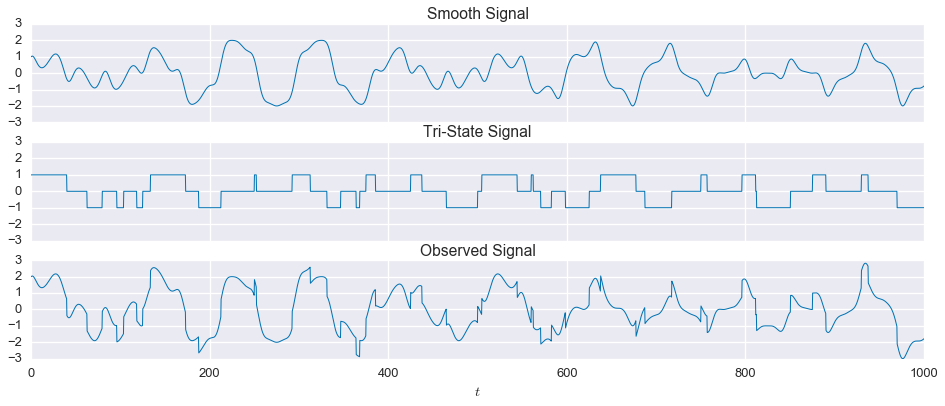

In [3]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(16,6))
ax[0].plot(t, signal1, linewidth=1)
ax[1].plot(t, signal2, linewidth=1)
ax[2].plot(t, observed, linewidth=1)
ax[0].set_title('Smooth Signal')
ax[1].set_title('Tri-State Signal')
ax[2].set_title('Observed Signal')
ax[2].set_xlabel('$t$')
plt.show()

## Formulating the Convex Optimization Problem

To recap, we've collected the observed signal as data, and we'd like to estimate the two component signals. We assume that we know the following:

- The number of component signals ($K=2$)
- That one of the signals should be smooth
- That one of the signals is tri-state (-1, 0, 1)

Our model is

$$x[t] = s_1[t] + s_2[t],$$

and we seek to solve the optimization problem

$$\begin{alignat*}{2}
& \underset{\hat{x}, \hat{s}_1, \hat{s}_2}{\text{minimize}}
& & \quad \left\lVert x - \hat{x}\right\rVert_2 \\
& \text{subject to}
& & \quad \hat{x} = \hat{s}_1 + \hat{s}_2.
\end{alignat*}$$

In the above equation, $x\in\mathbf{R}^n$ is the problem data (observed signal), and $\hat{x}$, $\hat{s}_1$, and $\hat{s}_2$ are the problem variables. Of course, without any other constraints, a trivial solution to this is $s_1=x$ and $s_2=\mathbf{0}$. This is where the regularization functions come in. We reformulate the problem as follows

$$\begin{alignat*}{2}
& \underset{\hat{x}, \hat{s}_1, \hat{s}_2}{\text{minimize (w.r.t. $\mathbf{R}_{+}^3$)}}
& & \quad \left(\left\lVert x - \hat{x}\right\rVert_2, \phi_1(\hat{s}_1),\phi_2(\hat{s}_1) \right)\\
& \text{subject to}
& & \quad \hat{x} = \hat{s}_1 + \hat{s}_2.
\end{alignat*}$$

Assuming that the _regularization functions_, $\phi_i$, are convex, this is a convex, multi-criterion problem. There exist many [Pareto optimal](https://en.wikipedia.org/wiki/Pareto_efficiency) solutions, i.e. points where it is impossible to reduce any criterion without making the other criteria larger. Many of these solutions, unfortunately, do not do a good job of separating the signals, but others do. We'll have to use some heuristics to figure out which solutions are useful.

Now, we need to design our regularization functions. As mentioned before, we want one of the signals to be smooth. A good way to do this is by putting a penalty on the [$2^{\text{nd}}$-order finite difference](https://en.wikipedia.org/wiki/Finite_difference#Higher-order_differences) of $s_1$. The $2^{\text{nd}}$-order finite difference is a linear transform defined by the matrix $\mathcal{D}_{2}\in\mathbf{R}^{(n-2)\times n}$, which takes a signal, $s[t]\in\mathbf{R}^n$, and returns the signal 

$$s''[t] = \mathcal{D}_2 s[t] = s[t] - 2\cdot s[t+1] + s[t+2]\in\mathbf{R}^{n-2}.$$

It provides a discrete estimate of the $2^{\text{nd}}$ derivative of the original signal. In other words, this penalty selects for a signal that does not have rapid in changes in slope, a reasonable definition for something smooth. So, we define

$$\phi_1(s)=\left\lVert \mathcal{D}_2 s \right\rVert_2.$$

This is a convex function in $s$, so our problem is still convex. We want the second signal to be tri-state, but 
limiting the entries of $\hat{s}_2$ to be in the set $\{-1,0,1\}$ is non-convex constraint, so cannot directly encode this information. Instead, we can restrict $\hat{s}_2$ to the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of its feasible set

$$ -1 \preceq \hat{s}_2 \preceq 1 $$

and penalize the _total variation_ of the signal, defined as

$$\phi_{\text{tv}}(s) = \sum_{i=1}^{n-1}\left\lvert s[t+1] - s[t] \right\rvert = \left\lVert \mathcal{D}_1 s\right\rVert_1.$$

This penalty selects for a signal that has a sparse $1^{\text{st}}$-order difference. Unlike the previous smoothing function, this function allows for a small number large "jumps" while keeping the rest of the signal "flat", which is a good heuristic for the tri-state behavior we are looking for. For now, we simply set $\phi_2=\phi_{\text{tv}}$. Later, when we introduce some noise, we'll see that we can make a small alteration to $\phi_2$ that gives much improved performance. 

Finally, we scalarize the multi-criterion by forming the weighted sum of the objective functions, allowing us to parameterize the optimal tradeoff frontier. This gives us the canonical convex minimization problem

$$\begin{alignat*}{2}
& \underset{\hat{x}, \hat{s}_1, \hat{s}_2}{\text{minimize}}
& & \quad \left\lVert x - \hat{x}\right\rVert_2 + \mu_1 \left\lVert \mathcal{D}_2 \hat{s}_1 \right\rVert_2 + \mu_2 \left\lVert \mathcal{D}_1 \hat{s}_2\right\rVert_1 \\
& \text{subject to}
& & \quad \hat{x} = \hat{s}_1 + \hat{s}_2,\quad -1 \preceq \hat{s}_2 \preceq 1.
\end{alignat*}$$

As a reference point, let's now evaluate the value of our two regularization functions on the original component signals. 

In [4]:
ph1 = cvx.norm(cvx.diff(signal1, k=2), 2).value
ph2 = cvx.norm(cvx.diff(signal2, k=1), 1).value
print 'phi_1 actual:  {:.2f}'.format(ph1)
print 'phi_2 actual: {:.1f}'.format(ph2)

phi_1 actual:  0.13
phi_2 actual: 48.0


### Selecting Hyperparameters

While we won't know this information in a "real" problem instance, it's good to have some sense of what values are reaasonable for these functions, when we look at how to select useful points for the set of parateo-optimal solutions. Next, we'll use `cvxpy` to explore the Pareto optimal frontier and look for a particular solution that gives a useful separation of the signal.

In [5]:
s1_hat = cvx.Variable(len(t))
s2_hat = cvx.Variable(len(t))
mu1 = cvx.Parameter(sign='positive', value=15)
mu2 = cvx.Parameter(sign='positive', value=.1)
mu3 = cvx.Parameter(sign='positive', value=1e-6)
f1 = cvx.norm(observed - (s1_hat + s2_hat))
f2 = mu1 * cvx.norm(cvx.diff(s1_hat, k=2), 2)
f3 = mu2 * cvx.norm(cvx.diff(s2_hat, k=1), 1)
f4 = mu3 * cvx.norm(s2_hat, 1)
objective = cvx.Minimize(f1 + f2 + f3 + f4)
constraints = [
    cvx.sum_entries(s2_hat) == 0,
    s2_hat >= -1,
    s2_hat <= 1
]
output1 = []
for m1 in np.logspace(0, 2, 21):
    for m2 in  np.linspace(.01,1,21):
        mu1.value = m1
        mu2.value = m2
        problem = cvx.Problem(objective, constraints)
        problem.solve(solver='MOSEK')
        output1.append([f2.value/mu1.value, f3.value/mu2.value, f1.value, m1, m2])
output1 = np.array(output1).T

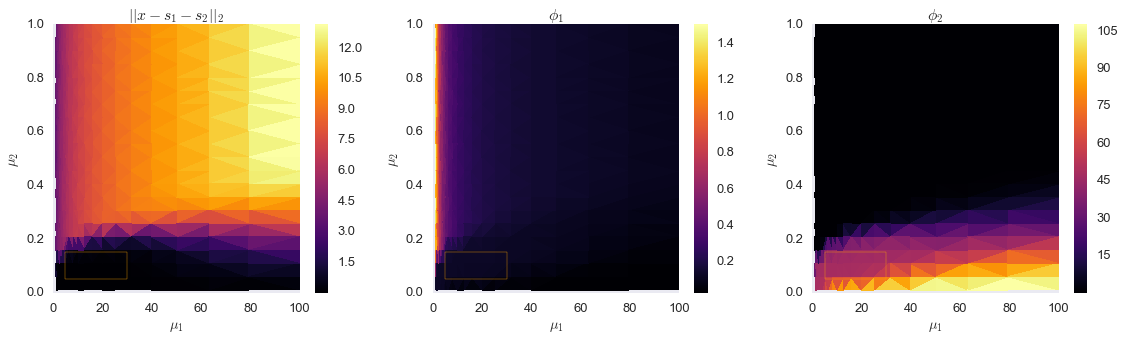

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
box = plt.Rectangle((5, 0.05), 30, 0.1, alpha=0.5)
im0 = ax[0].tripcolor(output1[3], output1[4], output1[2], cmap='inferno')
ax[0].set_xlabel('$\\mu_1$')
ax[0].set_ylabel('$\\mu_2$')
fig.colorbar(im0, ax=ax[0])
ax[0].set_title('$|| x - s_1 - s_2 ||_2$')
im1 = ax[1].tripcolor(output1[3], output1[4], output1[0], cmap='inferno')
ax[1].set_xlabel('$\\mu_1$')
ax[1].set_ylabel('$\\mu_2$')
fig.colorbar(im1, ax=ax[1])
ax[1].set_title('$\\phi_1$')
im2 = ax[2].tripcolor(output1[3], output1[4], output1[1], cmap='inferno')
ax[2].set_xlabel('$\\mu_1$')
ax[2].set_ylabel('$\\mu_2$')
fig.colorbar(im2, ax=ax[2])
ax[2].set_title('$\\phi_2$')
plt.tight_layout()
box1 = plt.Rectangle((5, 0.05), 25, 0.1, fill=False, edgecolor='orange')
box2 = plt.Rectangle((5, 0.05), 25, 0.1, fill=False, edgecolor='orange')
box3 = plt.Rectangle((5, 0.05), 25, 0.1, fill=False, edgecolor='orange')
ax[0].add_patch(box1)
ax[1].add_patch(box2)
ax[2].add_patch(box3)
plt.show()

The orange rectangles above show a stable region in the Pareto optimal frontier, which corresponds to objective functions values close to what we measured on the true component signals. Let's evaluate that range of $\mu_1$ and $\mu_2$ more closely.

In [7]:
output2 = []
for m1 in np.linspace(5, 25, 21):
    for m2 in  np.linspace(.05,.15,21):
        mu1.value = m1
        mu2.value = m2
        problem = cvx.Problem(objective, constraints)
        problem.solve(solver='MOSEK')
        output2.append([f2.value/mu1.value, f3.value/mu2.value, f1.value, m1, m2])
output2 = np.array(output2).T

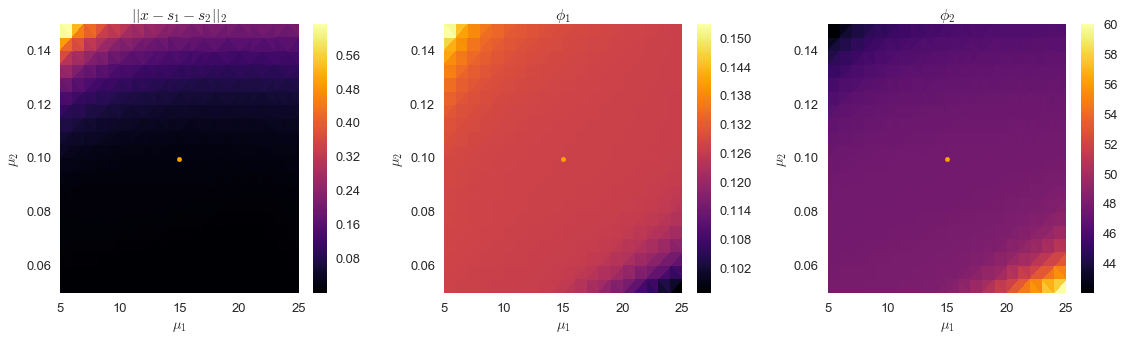

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
im0 = ax[0].tripcolor(output2[3], output2[4], output2[2], cmap='inferno')
ax[0].set_xlabel('$\\mu_1$')
ax[0].set_ylabel('$\\mu_2$')
fig.colorbar(im0, ax=ax[0])
ax[0].set_title('$|| x - s_1 - s_2 ||_2$')
im1 = ax[1].tripcolor(output2[3], output2[4], output2[0], cmap='inferno')
ax[1].set_xlabel('$\\mu_1$')
ax[1].set_ylabel('$\\mu_2$')
fig.colorbar(im1, ax=ax[1])
ax[1].set_title('$\\phi_1$')
im2 = ax[2].tripcolor(output2[3], output2[4], output2[1], cmap='inferno')
ax[2].set_xlabel('$\\mu_1$')
ax[2].set_ylabel('$\\mu_2$')
fig.colorbar(im2, ax=ax[2])
ax[2].set_title('$\\phi_2$')
plt.tight_layout()
for i in xrange(3):
    ax[i].scatter([15], [0.1], color='orange')
    ax[i].set_xlim(5, 25)
    ax[i].set_ylim(.05, .15)
plt.show()

### Signal Separation

In the second set of plots above, we've shown the point corresponding to $\mu_1=15$ and $\mu_2=0.1$, which we can see is close to the center of this stable region. We'll use these values, and see how well we can separate the signal.

In [9]:
x_hat = cvx.Variable(len(t))
s1_hat = cvx.Variable(len(t))
s2_hat = cvx.Variable(len(t))
mu1 = cvx.Parameter(sign='positive', value=15)
mu2 = cvx.Parameter(sign='positive', value=.1)
f1 = cvx.norm(observed - x_hat)
f2 = mu1 * cvx.norm(cvx.diff(s1_hat, k=2), 2)
f3 = mu2 * cvx.norm(cvx.diff(s2_hat, k=1), 1)
objective = cvx.Minimize(f1 + f2 + f3)
constraints = [
    x_hat == s1_hat + s2_hat,
    s2_hat >= -1,
    s2_hat <= 1
]
problem = cvx.Problem(objective, constraints)
problem.solve(solver='MOSEK')
s1 = 'Problem value: {:.2f}\n'
s2 = 'f1 value:       {:.2f}\n'
s3 = 'phi1 value:     {:.2f}\n'
s4 = 'phi2 value:    {:.2f}\n'
print (s1+s2+s3+s4).format(problem.value, f1.value, f2.value/mu1.value, f3.value/mu2.value)

Problem value: 6.71
f1 value:       0.01
phi1 value:     0.13
phi2 value:    47.84



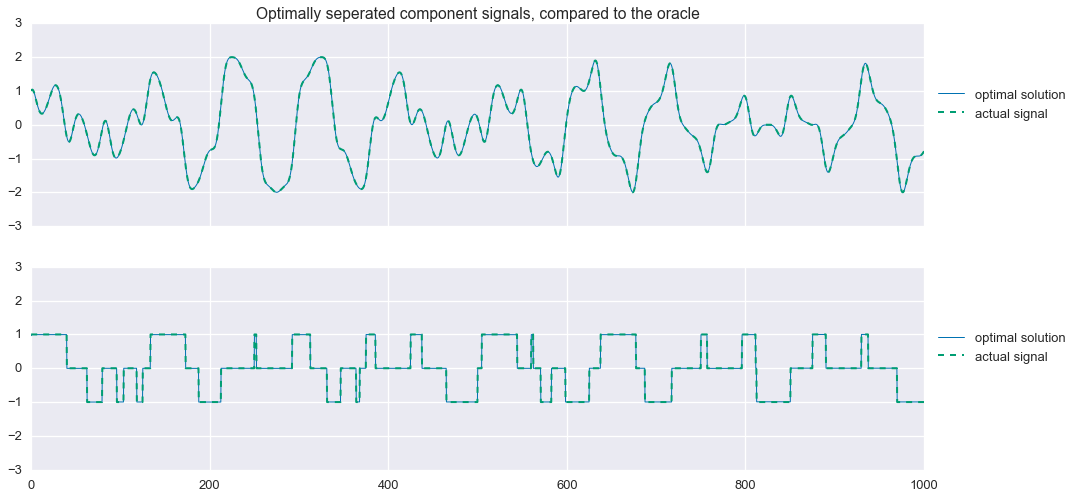

In [10]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(16,8))
ax[0].plot(t, s1_hat.value.A1, linewidth=1, label='optimal solution')
ax[0].plot(t, signal1, linewidth=2, ls='--', label='actual signal')
ax[1].plot(t, s2_hat.value.A1, linewidth=1, label='optimal solution')
ax[1].plot(t, signal2, linewidth=2, ls='--', label='actual signal')
ax[0].legend(loc=(1.01,.5))
ax[1].legend(loc=(1.01,.5))
ax[0].set_title('Optimally seperated component signals, compared to the oracle')
plt.show()

Not bad! That's almost a perfect reconstruction of the component signals. Looking closely at the residuals, we see that $\hat{s}_2$ is not exactly the tri-state signal we are looking for:

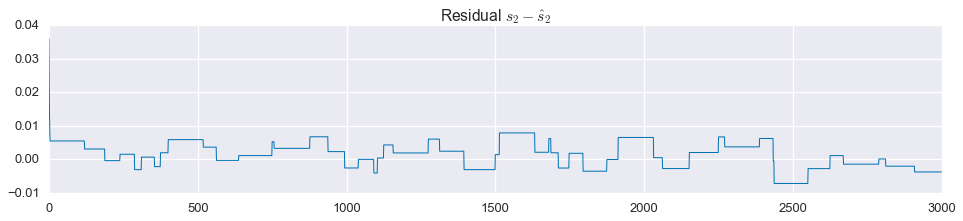

In [11]:
plt.figure(figsize=(16, 3))
plt.plot(signal2 - s2_hat.value.A1, linewidth=1)
plt.title('Residual $s_2 - \\hat{s}_2$')
plt.show()

That said, we could easily project this onto the set $\left\{-1,0,1\right\}$ and get a perfect reconstruction of the original signals.

## Adding Noise

Now let's make things a little more interesting and add some measurement noise. We'll use Gaussian, white noise with a mean of zero and a standard deviation of $0.1$, or $10\%$ of the step size in the tri-state signal. 

In [12]:
np.random.seed(1)
noise = 0.1 * np.random.randn(3000)
observed = signal1 + signal2 + noise

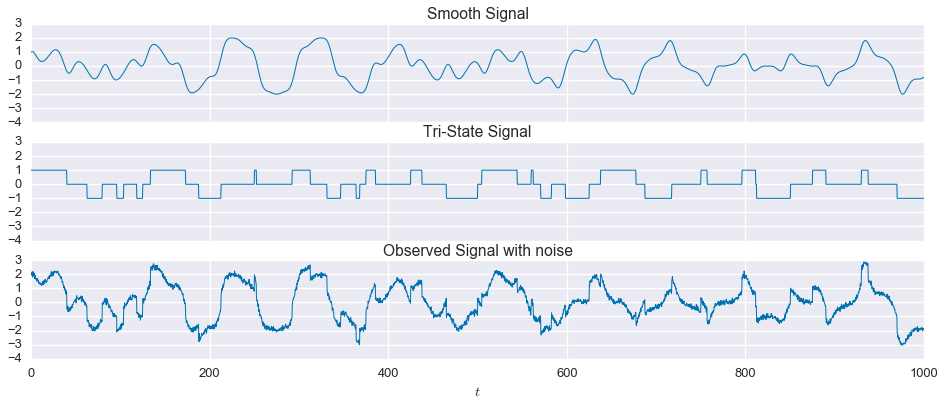

In [13]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(16,6))
ax[0].plot(t, signal1, linewidth=1)
ax[1].plot(t, signal2, linewidth=1)
ax[2].plot(t, observed, linewidth=1)
ax[0].set_title('Smooth Signal')
ax[1].set_title('Tri-State Signal')
ax[2].set_title('Observed Signal with noise')
ax[2].set_xlabel('$t$')
plt.show()

Okay, we have our noise observation of the mixed signal. Let's see how the approach we developed above fares on this noisy version of the problem.

In [14]:
x_hat = cvx.Variable(len(t))
s1_hat = cvx.Variable(len(t))
s2_hat = cvx.Variable(len(t))
mu1 = cvx.Parameter(sign='positive', value=15)
mu2 = cvx.Parameter(sign='positive', value=.1)
f1 = cvx.norm(observed - x_hat)
f2 = mu1 * cvx.norm(cvx.diff(s1_hat, k=2), 2)
f3 = mu2 * cvx.norm(cvx.diff(s2_hat, k=1), 1)
objective = cvx.Minimize(f1 + f2 + f3)
constraints = [
    x_hat == s1_hat + s2_hat,
    s2_hat >= -1,
    s2_hat <= 1
]
problem = cvx.Problem(objective, constraints)
problem.solve(solver='MOSEK')
s1 = 'Problem value: {:.2f}\n'
s2 = 'f1 value:       {:.2f}\n'
s3 = 'phi1 value:     {:.2f}\n'
s4 = 'phi2 value:    {:.2f}\n'
print (s1+s2+s3+s4).format(problem.value, f1.value, f2.value/mu1.value, f3.value/mu2.value)

Problem value: 11.12
f1 value:       5.85
phi1 value:     0.13
phi2 value:    33.24



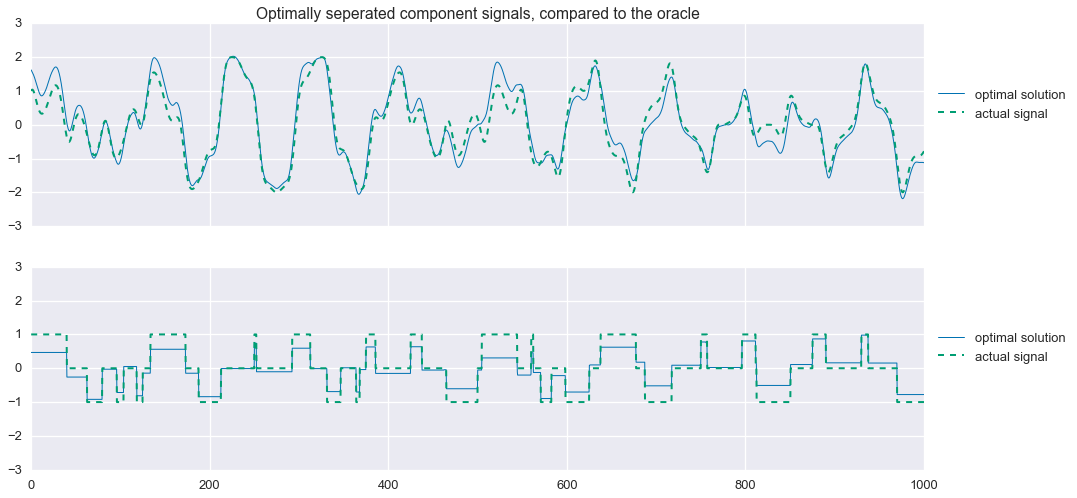

In [15]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(16,8))
ax[0].plot(t, s1_hat.value.A1, linewidth=1, label='optimal solution')
ax[0].plot(t, signal1, linewidth=2, ls='--', label='actual signal')
ax[1].plot(t, s2_hat.value.A1, linewidth=1, label='optimal solution')
ax[1].plot(t, signal2, linewidth=2, ls='--', label='actual signal')
ax[0].legend(loc=(1.01,.5))
ax[1].legend(loc=(1.01,.5))
ax[0].set_title('Optimally seperated component signals, compared to the oracle')
plt.show()

### Improving the estimates under noisy conditions

Now things are a bit more interesting. Unlike in the noise-free case, we now see some significant errors in the estimation of the comoponent signals. Of particular interest, we see that our estimation of the tri-state signal, while capturing the step-changes in the original signal, does a poor job of achieving the zero-values. Applying an $\ell_1$-norm penalty to this vector, sometimes known [lasso regularization](https://en.wikipedia.org/wiki/Lasso_%28statistics%29), encourages the vector to be sparse, meaning it has many zero entries. So, we alter the second regularization function with a "little bit" of lasso regularization like so:

$$ \phi_2(s) = \phi_{\text{tv}}(s) + 10^{-3}\cdot \left\lVert s \right\rVert_1. $$

As we'll now see, this helps to "center" the estimate of the tri-state signal.

In [16]:
s1_hat = cvx.Variable(len(t))
s2_hat = cvx.Variable(len(t))
mu1 = cvx.Parameter(sign='positive', value=15)
mu2 = cvx.Parameter(sign='positive', value=.1)
mu3 = cvx.Parameter(sign='positive', value=1e-4)
f1 = cvx.norm(observed - (s1_hat + s2_hat))
f2 = mu1 * cvx.norm(cvx.diff(s1_hat, k=2), 2)
f3 = mu2 * cvx.norm(cvx.diff(s2_hat, k=1), 1)
f4 = mu3 * cvx.norm(s2_hat, 1)
objective = cvx.Minimize(f1 + f2 + f3 + f4)
constraints = [
    s2_hat >= -1,
    s2_hat <= 1
]
problem = cvx.Problem(objective, constraints)
problem.solve(solver='MOSEK')
s1 = 'Problem value: {:.2f}\n'
s2 = 'f1 value:       {:.2f}\n'
s3 = 'phi1 value:     {:.2f}\n'
s4 = 'phi2 value:    {:.2f}\n'
print (s1+s2+s3+s4).format(problem.value, f1.value, f2.value/mu1.value, f3.value/mu2.value)

Problem value: 11.23
f1 value:       5.90
phi1 value:     0.13
phi2 value:    32.59



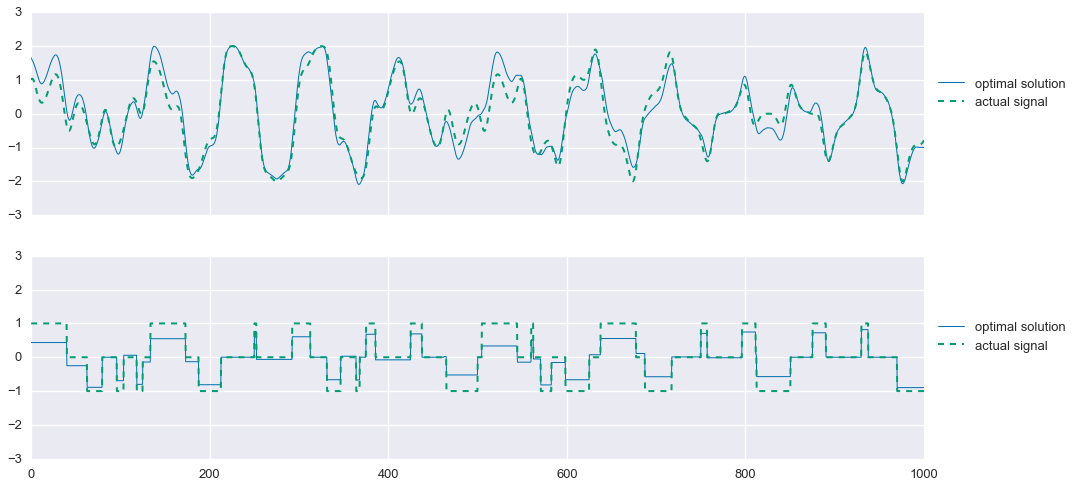

In [17]:
s2_proj = np.zeros_like(t)
s2_proj[s2_hat.value.A1 > 0.2] = 1
s2_proj[s2_hat.value.A1 < -0.2] = -1
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(16,8))
ax[0].plot(t, s1_hat.value.A1, linewidth=1, label='optimal solution')
ax[0].plot(t, signal1, linewidth=2, ls='--', label='actual signal')
ax[1].plot(t, s2_hat.value.A1, linewidth=1, label='optimal solution')
#ax[1].plot(t, s2_proj, linewidth=1, alpha=.5, label='projected')
ax[1].plot(t, signal2, linewidth=2, ls='--', label='actual signal')
ax[0].legend(loc=(1.01,.5))
ax[1].legend(loc=(1.01,.5))
plt.show()

Much better. As mentioned earlier, we can now project the solution for $\hat{s}_2$ onto the feasible set $\{-1,0,1\}$. We'll use the following projection:

$$ \pi(\hat{s}_2[t]) = \begin{cases}
1 & \text{if } \hat{s}_2[t] > \frac{1}{4} \\
0 & \text{if } -\frac{1}{4} \leq \hat{s}_2[t] \leq \frac{1}{4} \\
-1 & \text{if } \hat{s}_2[t] < -\frac{1}{4}
\end{cases}$$

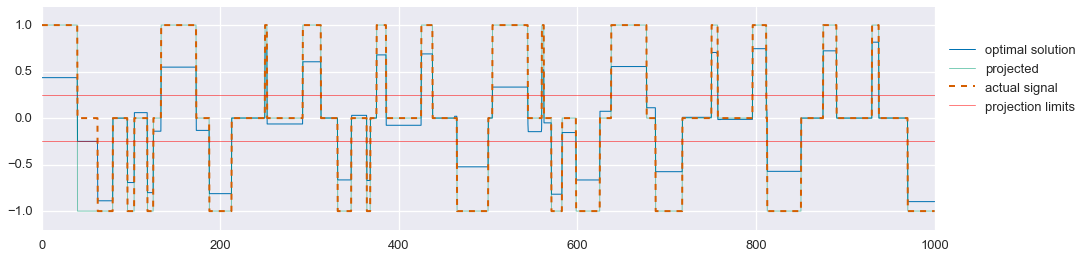

In [18]:
s2_proj = np.zeros_like(t)
s2_proj[s2_hat.value.A1 > 0.25] = 1
s2_proj[s2_hat.value.A1 < -0.25] = -1
fig, ax = plt.subplots(nrows=1, figsize=(16,4))
ax.plot(t, s2_hat.value.A1, linewidth=1, label='optimal solution')
ax.plot(t, s2_proj, linewidth=1, alpha=.5, label='projected')
ax.plot(t, signal2, linewidth=2, ls='--', label='actual signal')
plt.axhline(0.25, linewidth=1, color='red', alpha=0.5, label='projection limits')
plt.axhline(-0.25, linewidth=1, color='red', alpha=0.5)
ax.set_ylim(-1.2, 1.2)
ax.legend(loc=(1.01,.5))
plt.show()

If we now freeze our estimate of $s_2$ as this projected signal, we can resolved for $\hat{s}_1$ and get a better estimate of the smooth signal.

In [19]:
mu1 = cvx.Parameter(sign='positive', value=30)
f1 = cvx.norm(observed - (s1_hat + s2_proj))
f2 = mu1 * cvx.norm(cvx.diff(s1_hat, k=2), 2)
objective = cvx.Minimize(f1 + f2)
problem = cvx.Problem(objective)
problem.solve(solver='MOSEK')

9.219480280097997

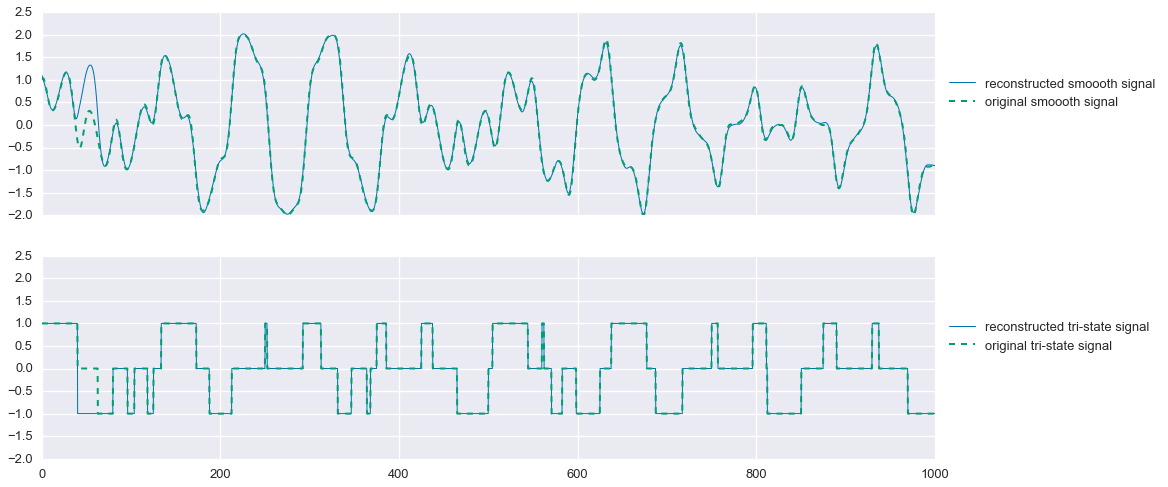

In [20]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(16,8))
ax[0].plot(t, s1_hat.value.A1, linewidth=1, label='reconstructed smoooth signal')
ax[0].plot(t, signal1, linewidth=2, ls='--', label='original smoooth signal')
ax[1].plot(t, s2_proj, linewidth=1, label='reconstructed tri-state signal')
ax[1].plot(t, signal2, linewidth=2, ls='--', label='original tri-state signal')
ax[0].legend(loc=(1.01,.5))
ax[1].legend(loc=(1.01,.5))
plt.show()

That's pretty good! In this problem instance, we miss one segment of the tri-state signal, causing us to also mis-estimate the smooth signal during that period. But still, not bad. One could potentially spend more time designing an optimal projection function that may solve this problem, but overall this method does quite well.

## Conclusion

In this post we've explored using convex optimization to perform single-channel blind source separation. We found that in the absense of noise, we can easily separate our example signals based on simple regularization functions, which capture our prior knowledge of the signals' behaviors—smoothness and sparse first-order differences. 

Adding noise to the problem makes it significantly harder, and it is no longer a trivial task to separate the signals. However, with the addition of two more heuristics—lasso regularization and projection onto the feasible set—we are able to get a very good estimate of the original signals. 